In [1]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D
from sklearn.metrics import classification_report,confusion_matrix

2024-06-15 17:00:47.742166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 17:00:47.742267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 17:00:48.004614: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dir = '/kaggle/input/emotion-augmented-terbaru/Autistic Children Emotion/Train'
test_dir  = '/kaggle/input/emotion-augmented-terbaru/Autistic Children Emotion/Test'

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=75,
        class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical'
)

Found 1740 images belonging to 6 classes.
Found 75 images belonging to 6 classes.


In [5]:
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [6]:
x = base_model.output
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((1,1))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(1,1)(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(1,1)(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(1,1)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [8]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if accuracy is not None and val_accuracy is not None:
            if accuracy > 0.9 or val_accuracy > 0.85:
                self.model.stop_training = True

callbacks = myCallback()

In [9]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/100


I0000 00:00:1718470879.370645     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - 45s 1s/step - loss: 1.7921 - accuracy: 0.1925 - val_loss: 1.7369 - val_accuracy: 0.0400
Epoch 2/100
24/24 [==============================] - 23s 953ms/step - loss: 1.7327 - accuracy: 0.2397 - val_loss: 1.6002 - val_accuracy: 0.0533
Epoch 3/100
24/24 [==============================] - 23s 972ms/step - loss: 1.6257 - accuracy: 0.2816 - val_loss: 1.6616 - val_accuracy: 0.0533
Epoch 4/100
24/24 [==============================] - 23s 963ms/step - loss: 1.5702 - accuracy: 0.3115 - val_loss: 1.6657 - val_accuracy: 0.0800
Epoch 5/100
24/24 [==============================] - 23s 952ms/step - loss: 1.5579 - accuracy: 0.3218 - val_loss: 1.6574 - val_accuracy: 0.1467
Epoch 6/100
24/24 [==============================] - 23s 968ms/step - loss: 1.4880 - accuracy: 0.3672 - val_loss: 1.5409 - val_accuracy: 0.4400
Epoch 7/100
24/24 [==============================] - 23s 965ms/step - loss: 1.4065 - accuracy: 0.4218 - val_loss: 1.6185 - val_accuracy: 0.3600
Epoch 8

In [10]:
g_dict = train_generator.class_indices     
classes = list(g_dict.keys())       

preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

# Classification report
print(classification_report(test_generator.classes, y_pred, target_names= classes))

8/8 [==============================] - 1s 31ms/step
              precision    recall  f1-score   support

     Natural       0.25      0.29      0.27         7
       anger       0.00      0.00      0.00         3
        fear       0.00      0.00      0.00         3
         joy       0.66      0.50      0.57        42
     sadness       0.18      0.14      0.16        14
    surprise       0.11      0.17      0.13         6

    accuracy                           0.35        75
   macro avg       0.20      0.18      0.19        75
weighted avg       0.43      0.35      0.38        75



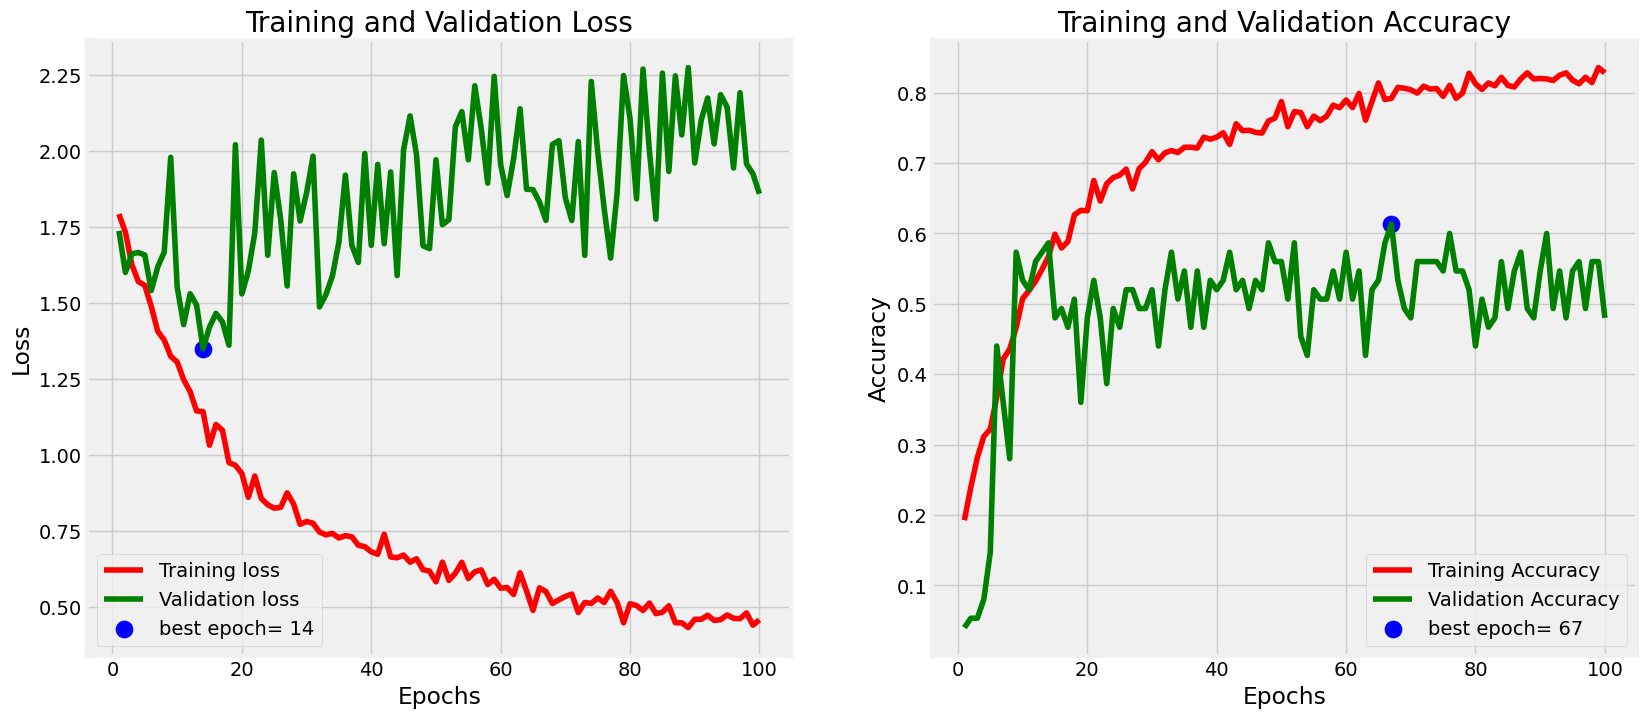

In [11]:
# Define needed variables
def f_history(history = history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

f_history(history)

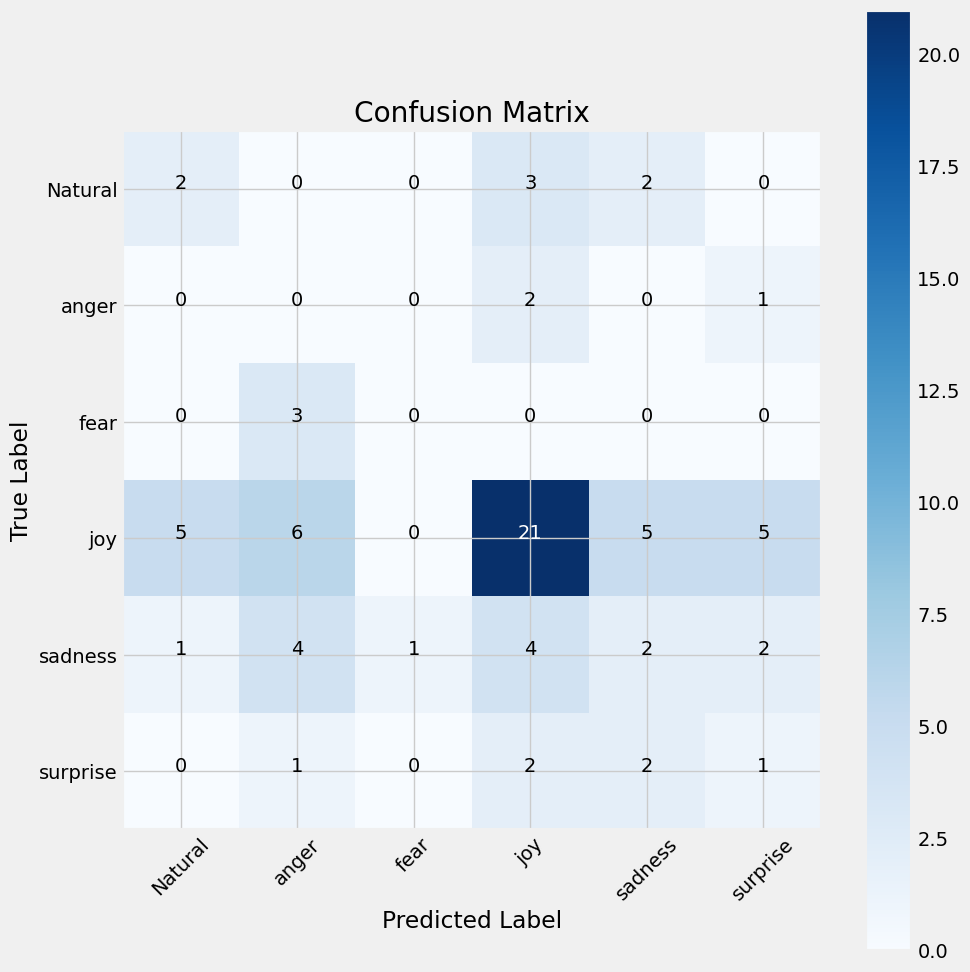

In [12]:
import itertools
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

    # Confusion matrix
def f_cm(y_pred = y_pred):
    cm = confusion_matrix(test_generator.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()

f_cm(y_pred)

In [13]:
model.save('mobilenetv2-emotion_aziz.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Convert Model to TFJS

In [14]:
!pip install tensorflowjs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


INFO: pip is looking at multiple versions of tensorstore to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tensorstore to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 65.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: tensorstore
    Found existing installation: tensorstore 0.1.60
    Uninstalling tensorstore-0.1.6

In [15]:
!tensorflowjs_converter --input_format keras /kaggle/working/mobilenetv2-emotion_aziz.h5 /kaggle/working/tfjs_model

2024-06-15 17:40:26.658035: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 17:40:26.658090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 17:40:26.659607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
